In [117]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from IPython.display import Markdown, display

import pypesto
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.visualize as visualize
import pypesto.sample as sample

logger = logging.getLogger("pypesto.sample.diagnostics")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


# set a random seed
np.random.seed(1912)

%matplotlib inline

In [80]:
# first type of objective defined through callables
objective1 = pypesto.Objective(
    fun=sp.optimize.rosen,
    grad=sp.optimize.rosen_der,
    hess=sp.optimize.rosen_hess,
)

# second type of objective
def rosen2(x):
    return (
        sp.optimize.rosen(x),
        sp.optimize.rosen_der(x),
        sp.optimize.rosen_hess(x),
    )


objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

# no hessian objective
objective3 = pypesto.Objective(
    fun=sp.optimize.rosen,
    grad=sp.optimize.rosen_der,
)

# neither hessian nor gradient objective
objective4 = pypesto.Objective(
    fun=sp.optimize.rosen,
)



In [109]:
dim_full = 15
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

# for the sake of comparison, we create 20 starts within these bounds
x_guesses = np.random.uniform(-5, 5, (20, dim_full))

problem1 = pypesto.Problem(
    objective=objective1, lb=lb, ub=ub, x_guesses=x_guesses
)
problem2 = pypesto.Problem(
    objective=objective2, lb=lb, ub=ub, x_guesses=x_guesses
)
problem3 = pypesto.Problem(
    objective=objective3, lb=lb, ub=ub, x_guesses=x_guesses
)
problem4 = pypesto.Problem(
    objective=objective4, lb=lb, ub=ub, x_guesses=x_guesses
)

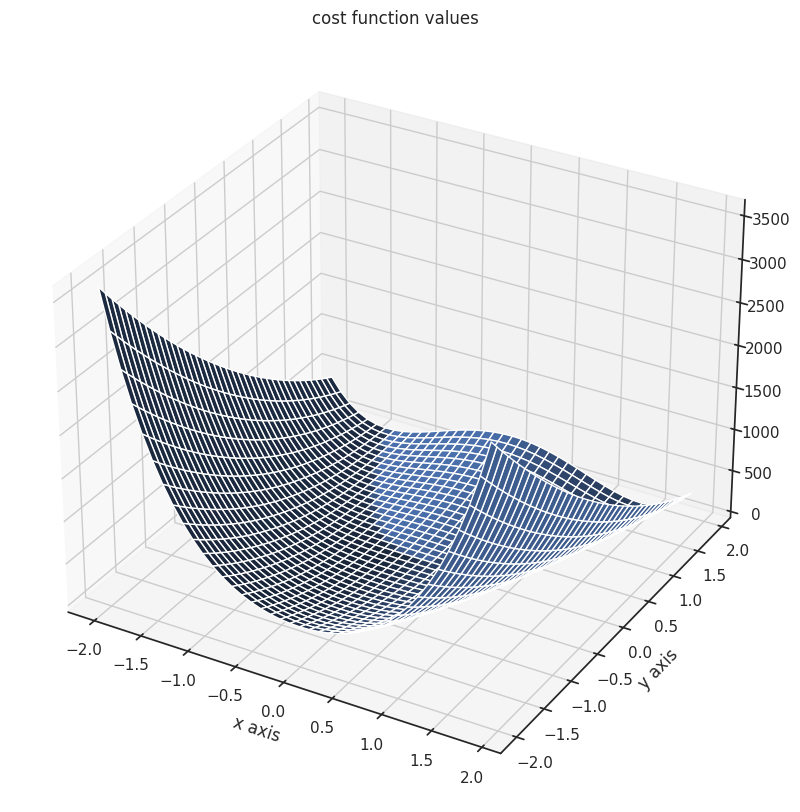

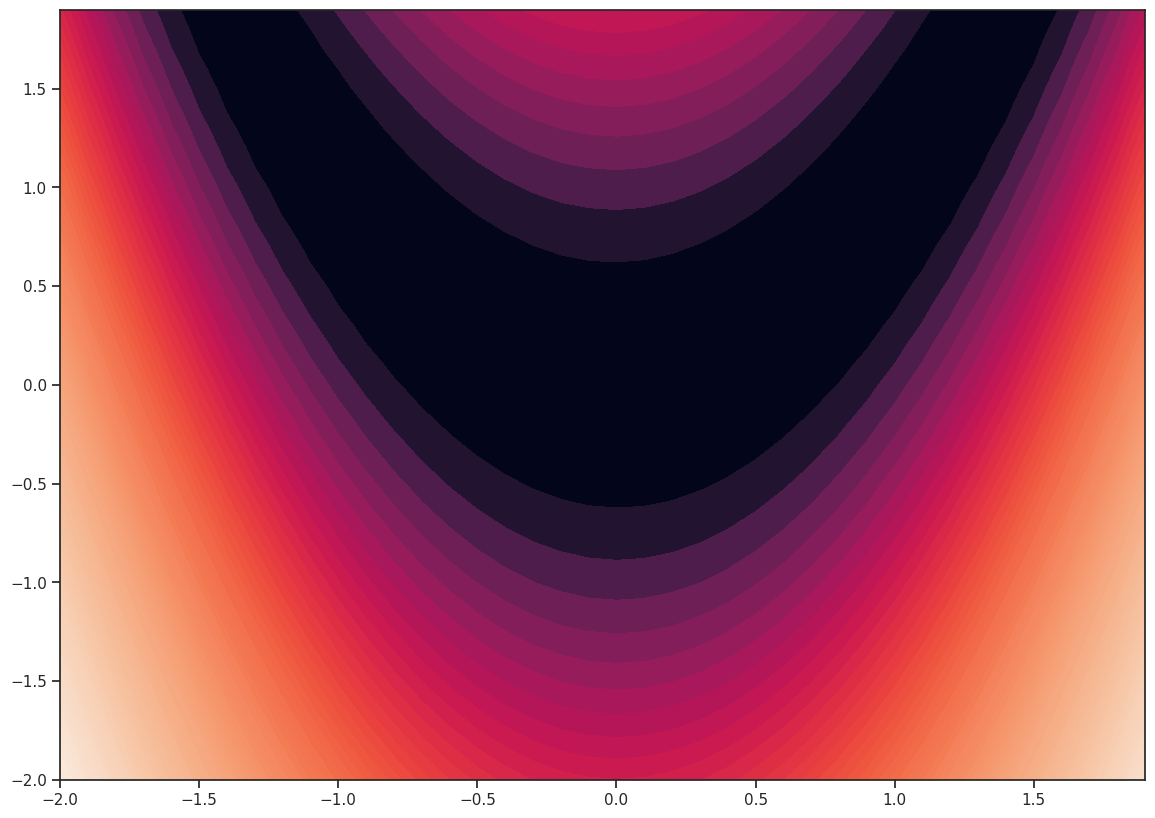

In [110]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j, k] = objective1([x[j, k], y[j, k]], (0,))
        
fig = plt.figure()
fig.set_size_inches(*(14, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(X=x, Y=y, Z=z)
plt.xlabel("x axis")
plt.ylabel("y axis")
ax.set_title("cost function values")

fig = plt.figure()
fig.set_size_inches(*(14, 10))
ax = plt.axes()
ax.contourf(x, y, z, 100, norm="log");



In [111]:
# optimizer
optimizer = optimize.ScipyOptimizer()
# engine
# In this notebook, it is faster to use a single core engine, due to the
# overhead of multiprocessing. But in general with more expensive problems
# it is recommended to use the MultiProcessEngine.
engine = pypesto.engine.SingleCoreEngine()
# starts
n_starts = 20

# run optimization of problem 1
result1 = optimize.minimize(
    problem=problem1, optimizer=optimizer, n_starts=n_starts, engine=engine
)
# run optimization of problem 2
result2 = optimize.minimize(
    problem=problem2, optimizer=optimizer, n_starts=n_starts, engine=engine
)
# run optimization of problem 3
result3 = optimize.minimize(
    problem=problem3, optimizer=optimizer, n_starts=n_starts, engine=engine
)
# run optimization of problem 4
result4 = optimize.minimize(
    problem=problem4, optimizer=optimizer, n_starts=n_starts, engine=engine
)



  0%|                                                    | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pypesto/optimize/optimizer.py:251: UserWarning: scipy.optimize.minimize does not support passing fun and hess as one function. Hence for each evaluation of hess, fun will be evaluated again. This can lead to increased computation times. If possible, separate fun and hess.
  return minimize(
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 18.97it/s]


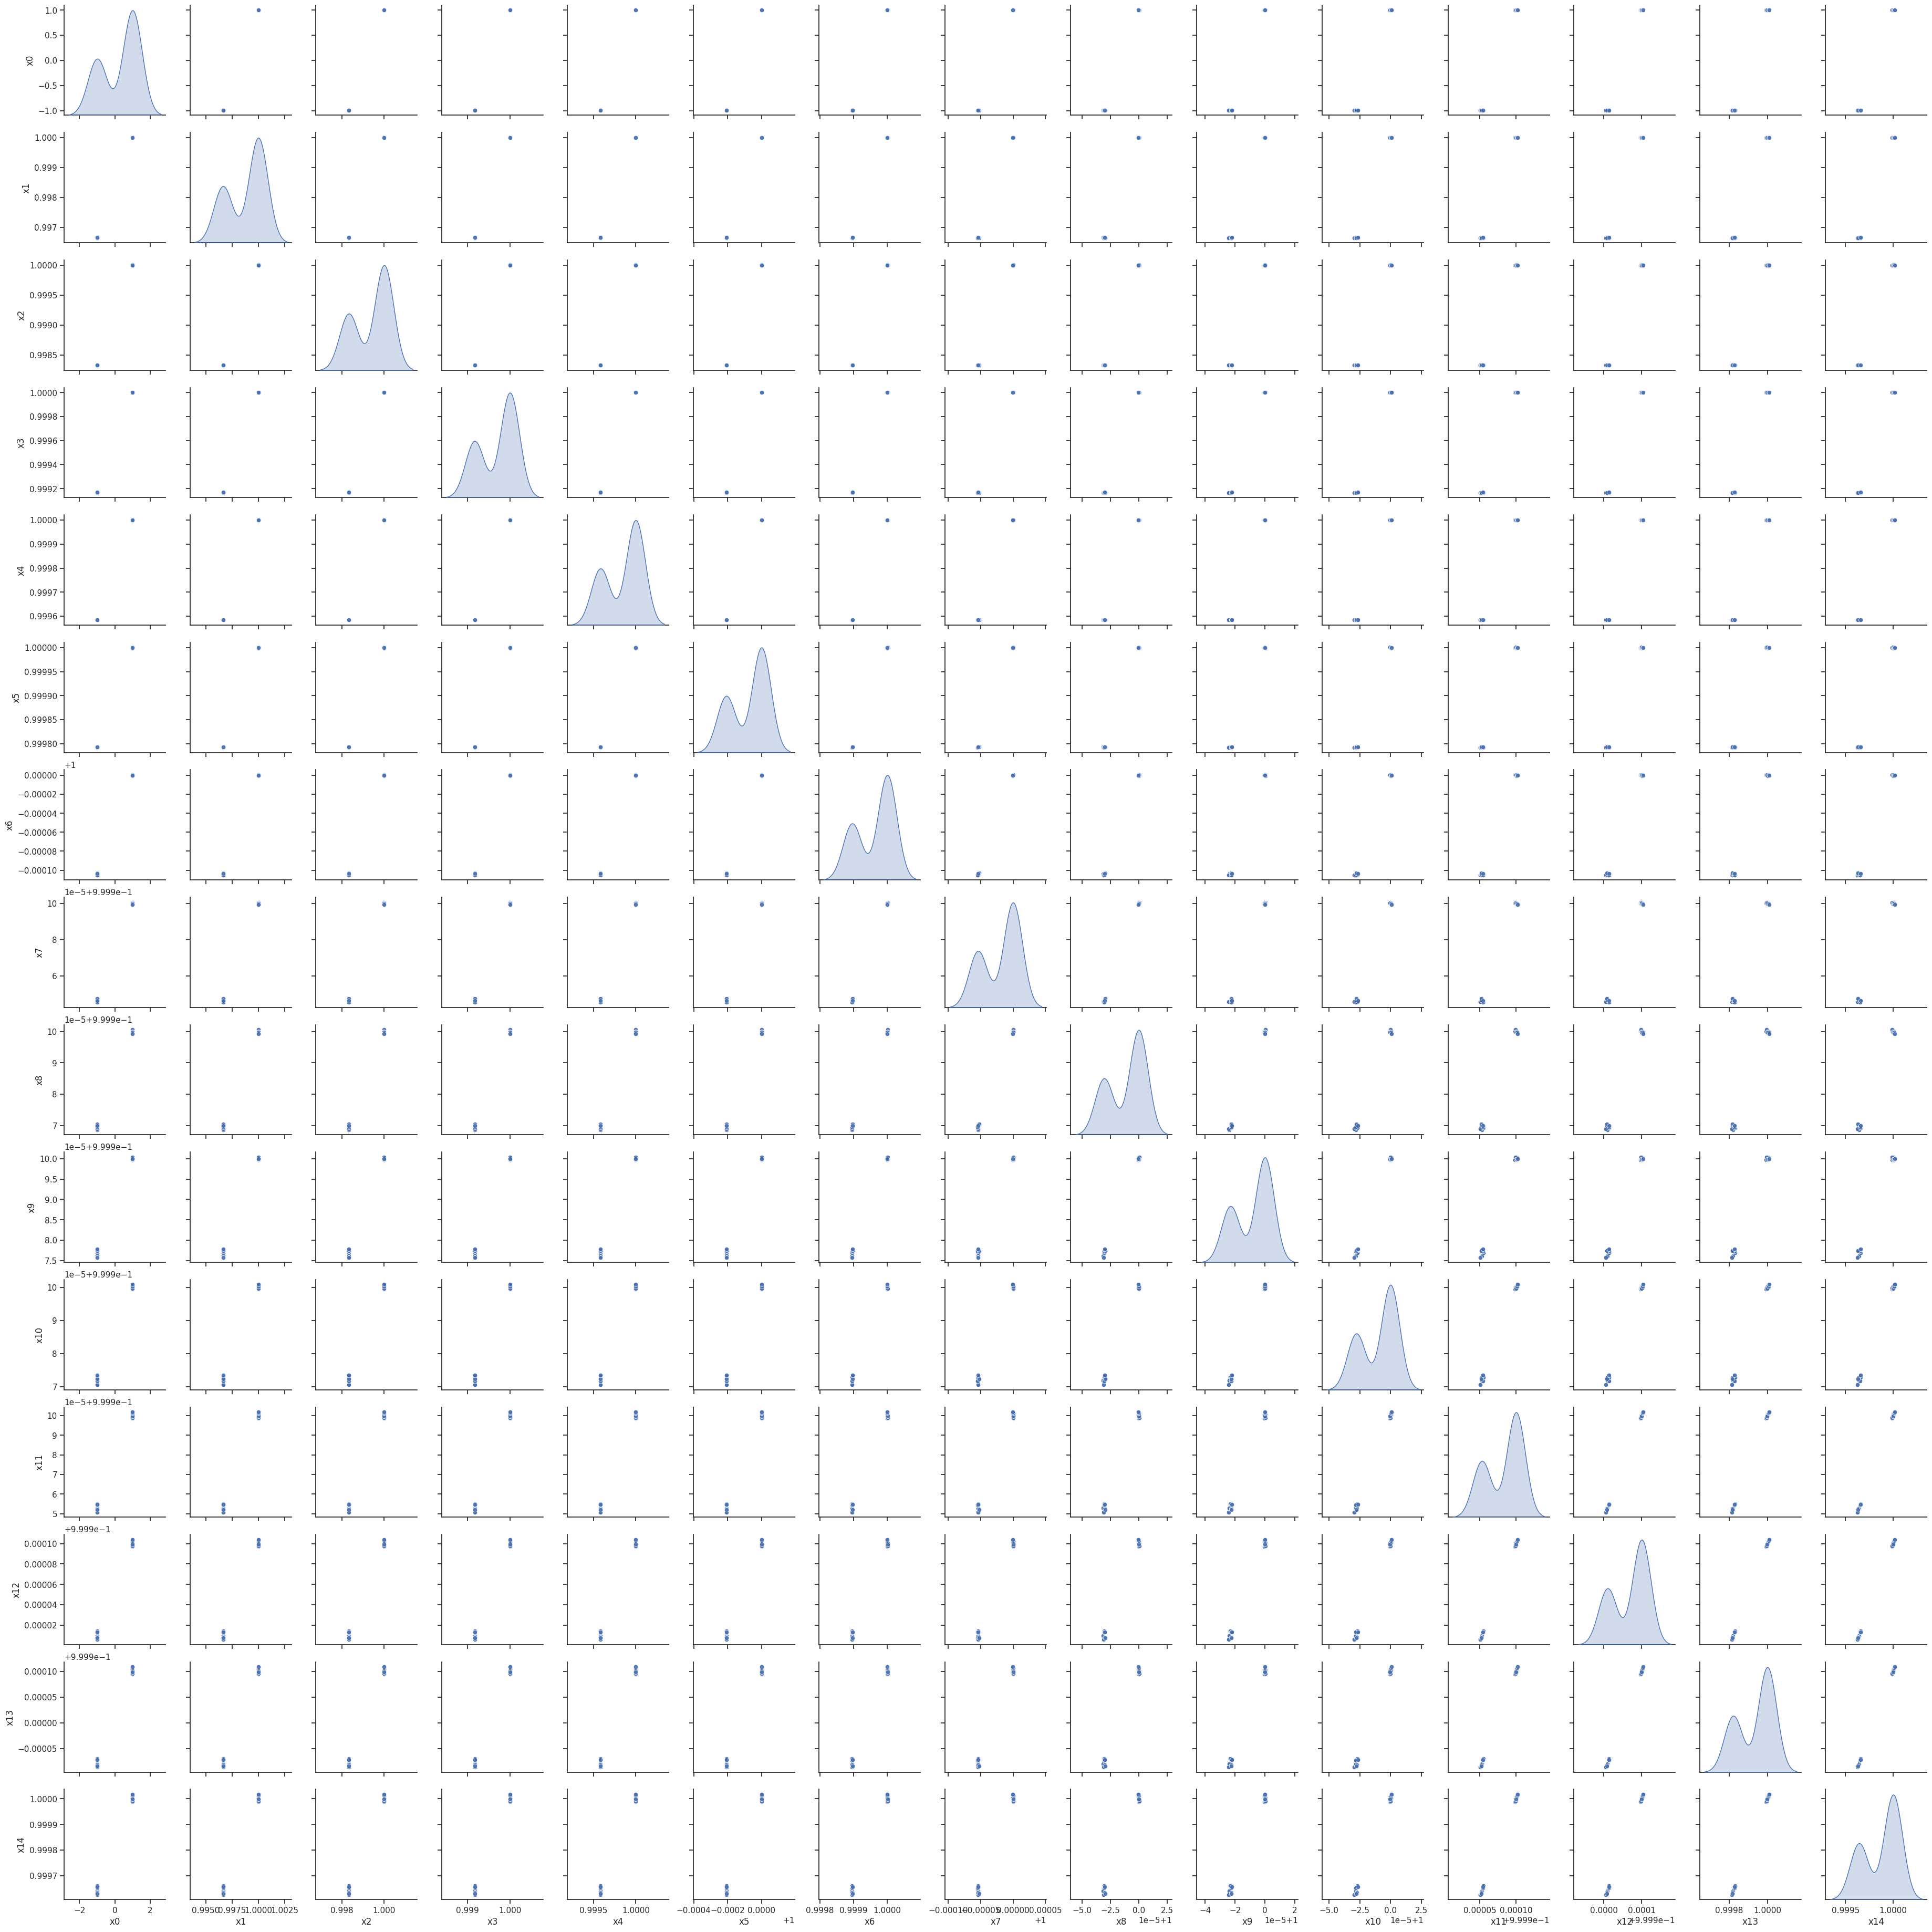

In [112]:
visualize.optimization_scatter(result=result1)

100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 13.15it/s]


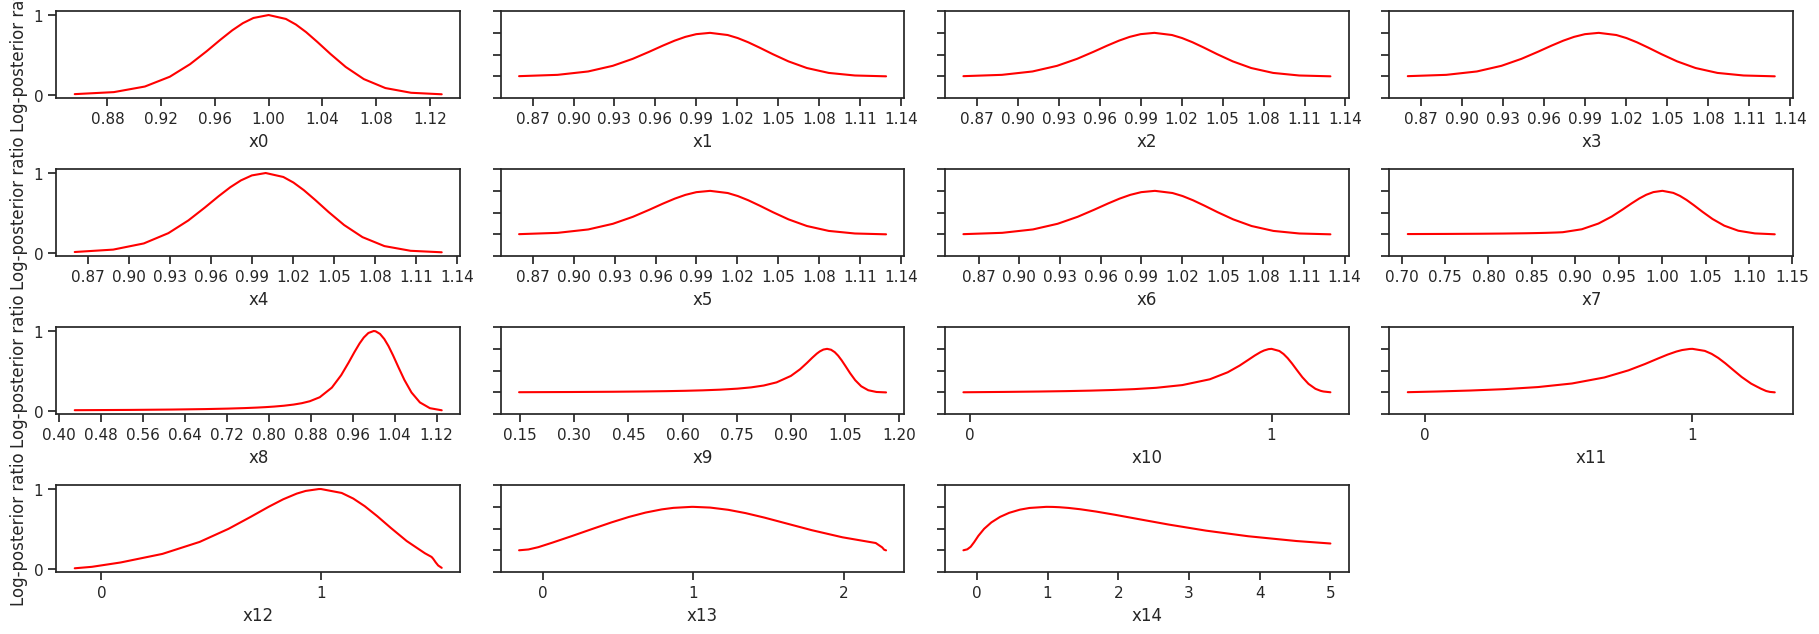

In [114]:
import pypesto.profile as profile

profile_options = profile.ProfileOptions(
    min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005,
    ratio_min=0.01,
)

result1 = profile.parameter_profile(
    problem=problem1,
    result=result1,
    optimizer=optimizer,
    # profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    # result_index=0,
    profile_options=profile_options,
    filename=None,
)


# specify the parameters, for which profiles should be computed
ax = visualize.profiles(result1)



In [115]:
import pypesto.sample as sample

sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3
)

result = sample.sample(
    problem1, n_samples=100000, sampler=sampler, result=result1, filename=None
)

Initializing betas with "near-exponential decay".
100%|█████████████████████████████████| 100000/100000 [01:05<00:00, 1531.24it/s]
Elapsed time: 65.38023409599992


/usr/local/lib/python3.10/dist-packages/pypesto/visualize/sampling.py:1223: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  nr_params, params_fval, theta_lb, theta_ub, _ = get_data_to_plot(


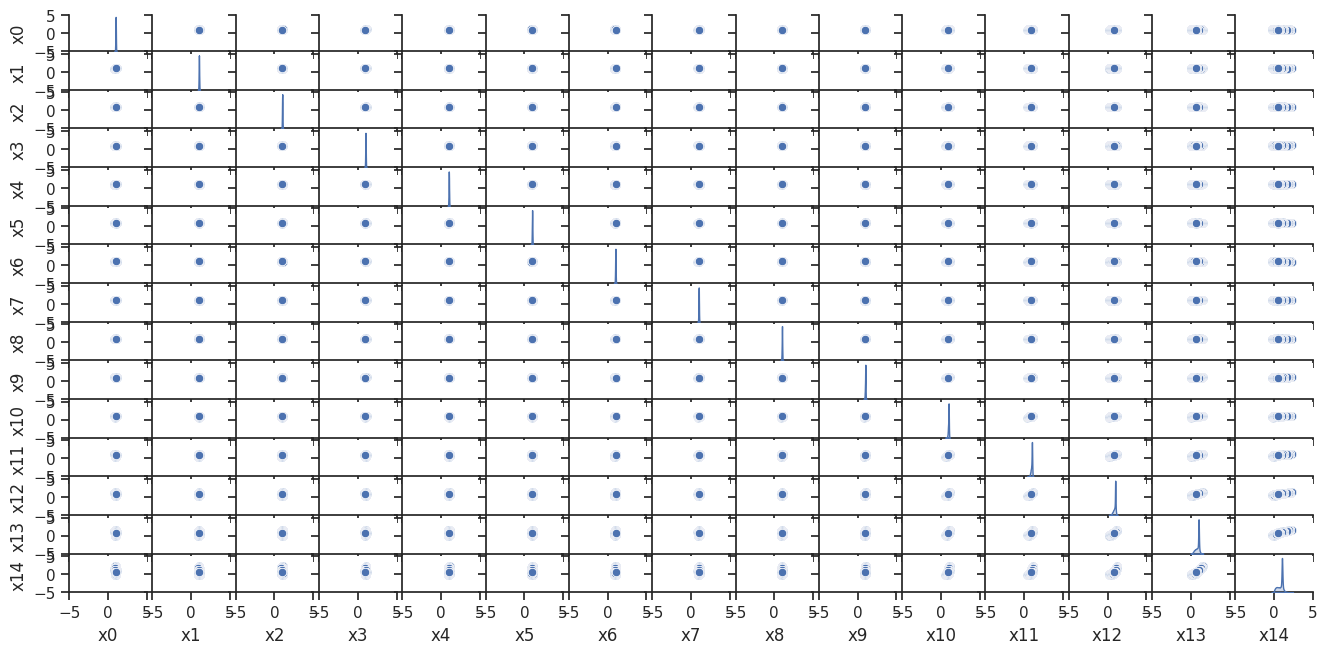

In [116]:
ax = visualize.sampling_scatter(result, size=[13, 6])

<Axes: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=1.000e+00)'>

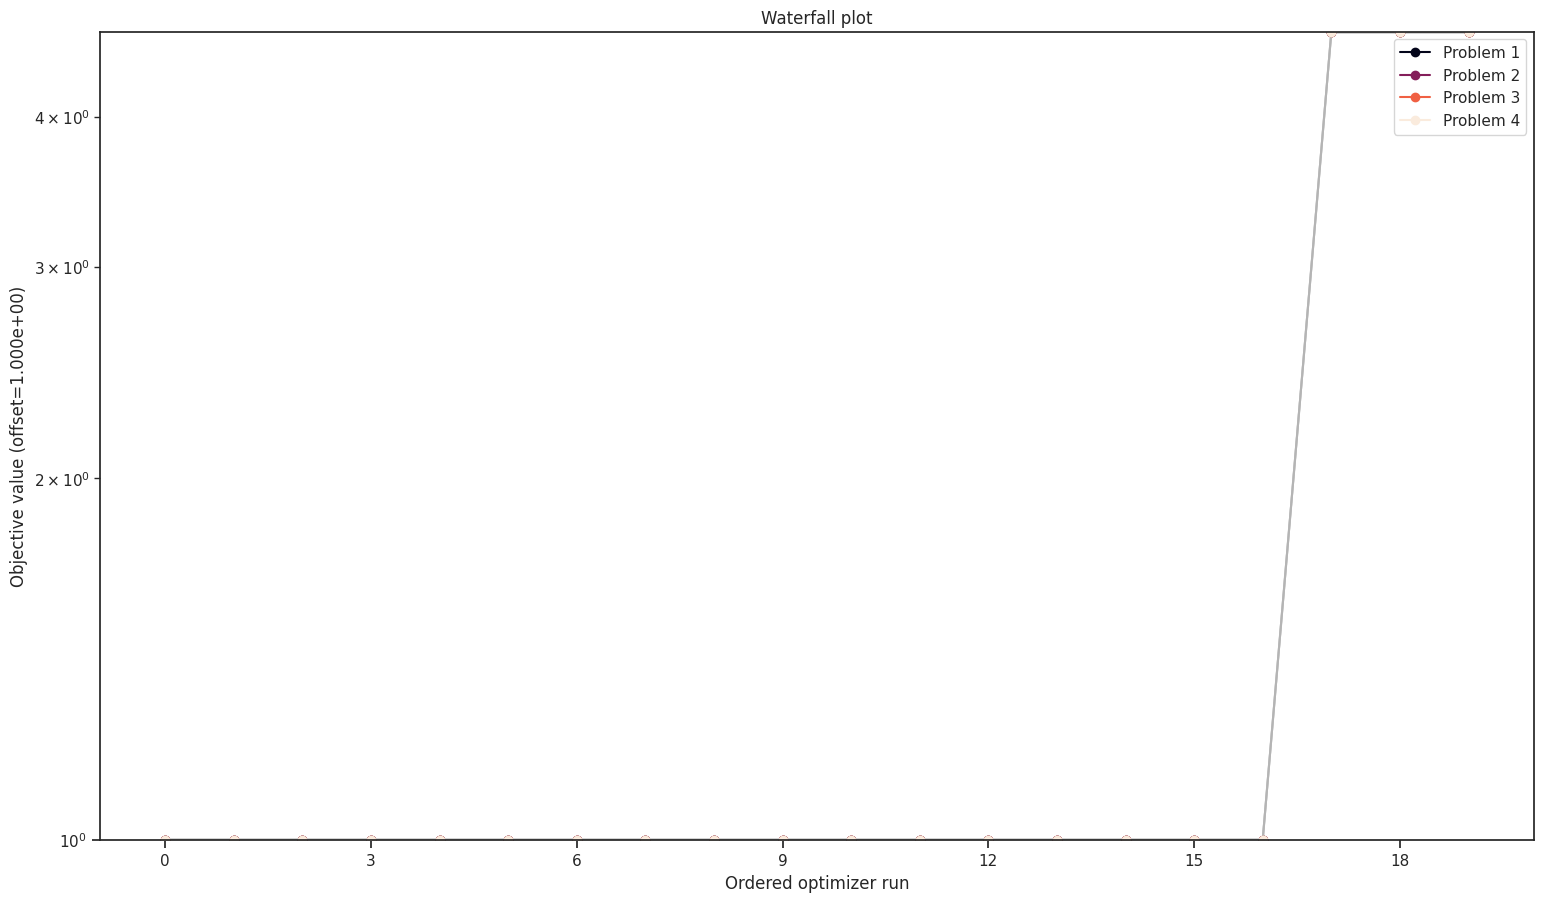

In [68]:
visualize.waterfall(
    [result1, result2, result3, result4],
    legends=["Problem 1", "Problem 2", "Problem 3", "Problem 4"],
)

/tmp/ipykernel_52215/1092192451.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Text(0.5, 1.0, 'Estimated parameters all problems')

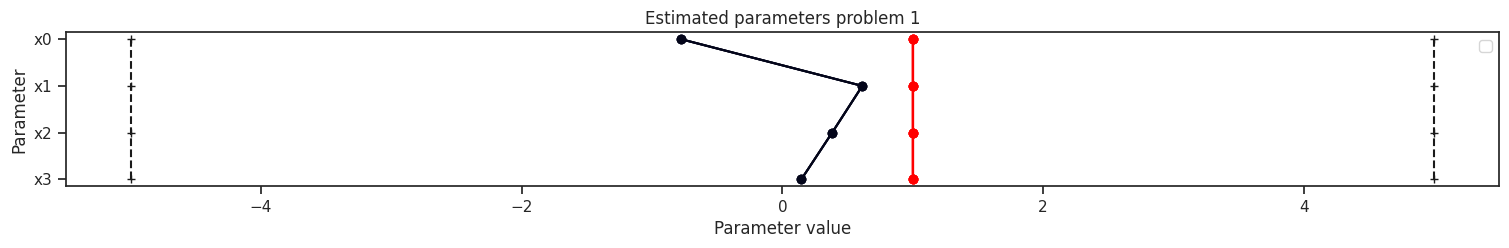

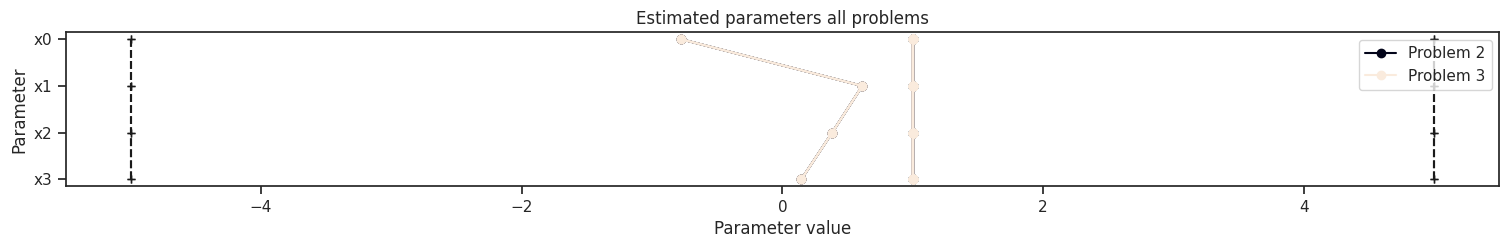

In [69]:
ax = visualize.parameters(
    result1,
)
ax.set_title("Estimated parameters problem 1")
ax.legend()
# ax2 = visualize.parameters(
#     [result4, result1, result2, result3],
#     legends=["Problem 4", "Problem 1", "Problem 2", "Problem 3"],
# )
# ax2.set_title("Estimated parameters all problems")

ax2 = visualize.parameters(
    [result2, result3],
    legends=["Problem 2", "Problem 3"],
)
ax2.set_title("Estimated parameters all problems")

In [71]:
# we create references for each "best point":
ref = {
    "x": result1.optimize_result.x[0],
    "fval": result1.optimize_result.fval[0],
    "color": [0.2, 0.4, 1.0, 1.0],
    "legend": "First optimum problem 1",
}
ref = visualize.create_references(ref)[0]
# we create references for each "best point":
ref2 = {
    "x": result1.optimize_result.x[-1],
    "fval": result1.optimize_result.fval[-1],
    "color": [0.4, 1.0, 0.2, 1.0],
    "legend": "Second optimum problem 1",
}
ref2 = visualize.create_references(ref2)[0]
# we create references for each "best point":
ref4 = {
    "x": result4.optimize_result.x[0],
    "fval": result4.optimize_result.fval[0],
    "color": [0.2, 0.4, 1.0, 1.0],
    "legend": "First optimum problem 4",
}
ref4 = visualize.create_references(ref4)[0];

In [87]:
# compute profiles
profile_options = profile.ProfileOptions(whole_path=True)

result1 = profile.parameter_profile(
    problem=problem1,
    result=result1,
    optimizer=optimizer,
    profile_index=np.array([0, 1, 3]),
    result_index=0,
    profile_options=profile_options,
    filename=None,
)

# compute profiles from second optimum
result1 = profile.parameter_profile(
    problem=problem1,
    result=result1,
    optimizer=optimizer,
    profile_index=np.array([0, 1, 3]),
    result_index=-1,
    profile_options=profile_options,
    filename=None,
)
result4 = profile.parameter_profile(
    problem=problem4,
    result=result4,
    optimizer=optimizer,
    profile_index=np.array([0, 1, 3]),
    result_index=0,
    profile_options=profile_options,
    filename=None,
)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


[<Axes: xlabel='x0', ylabel='Log-posterior ratio'>,
 <Axes: xlabel='x1'>,
 <Axes: xlabel='x3', ylabel='Log-posterior ratio'>]

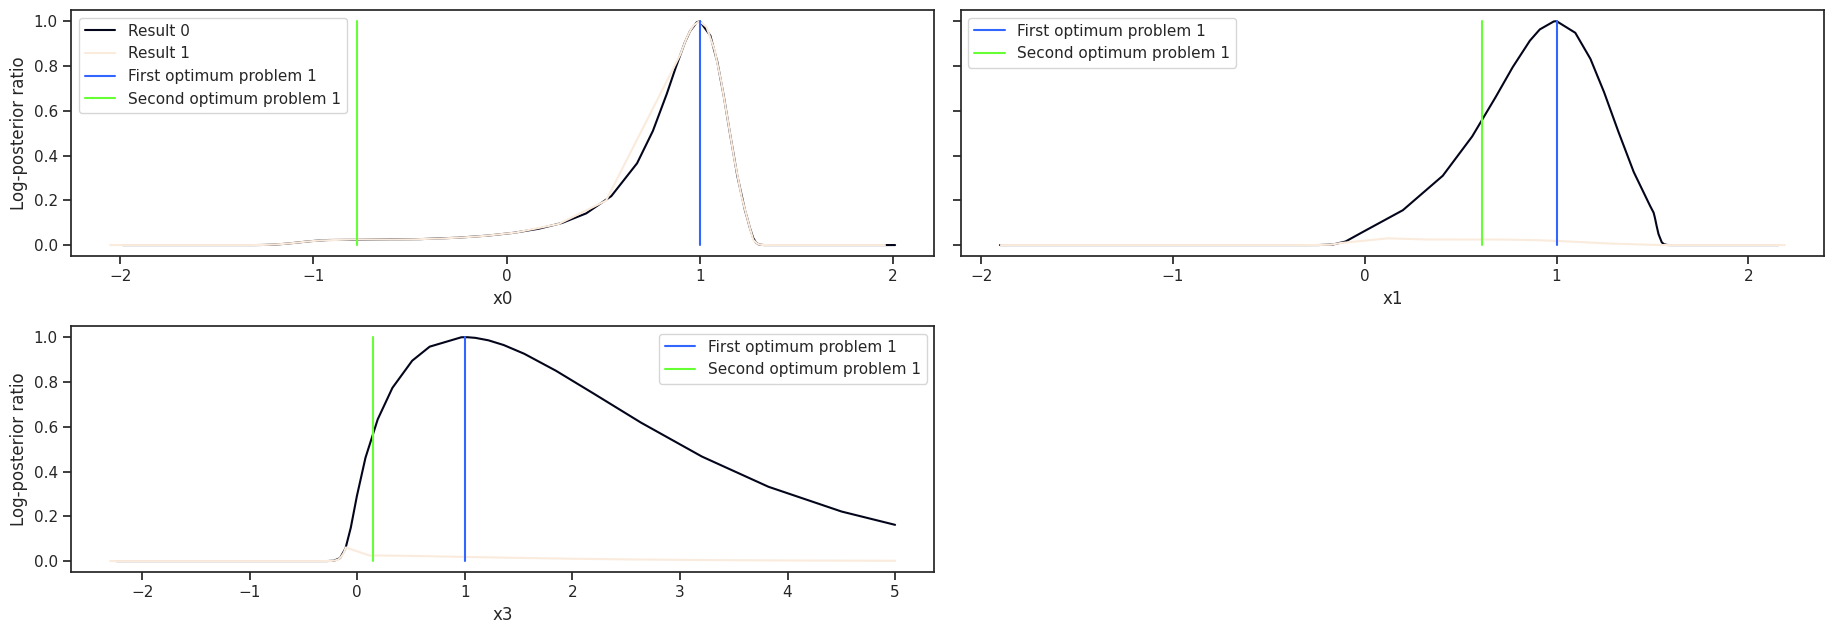

In [88]:
# specify the parameters, for which profiles should be computed
visualize.profiles(
    result1,
    profile_indices=[0, 1, 3],
    reference=[ref, ref2],
    profile_list_ids=[0, 1],
)

In [92]:
# ax = visualize.sampling_parameter_cis(result1, alpha=[0.9, 0.95, 0.99], size=(12, 5))

sample.calculate_ci_mcmc_sample(result1, ci_level=0.95, exclude_burn_in=True)

AttributeError: 'SampleResult' object has no attribute 'burn_in'

[<Axes: xlabel='x0', ylabel='Log-posterior ratio'>,
 <Axes: xlabel='x1'>,
 <Axes: xlabel='x3', ylabel='Log-posterior ratio'>]

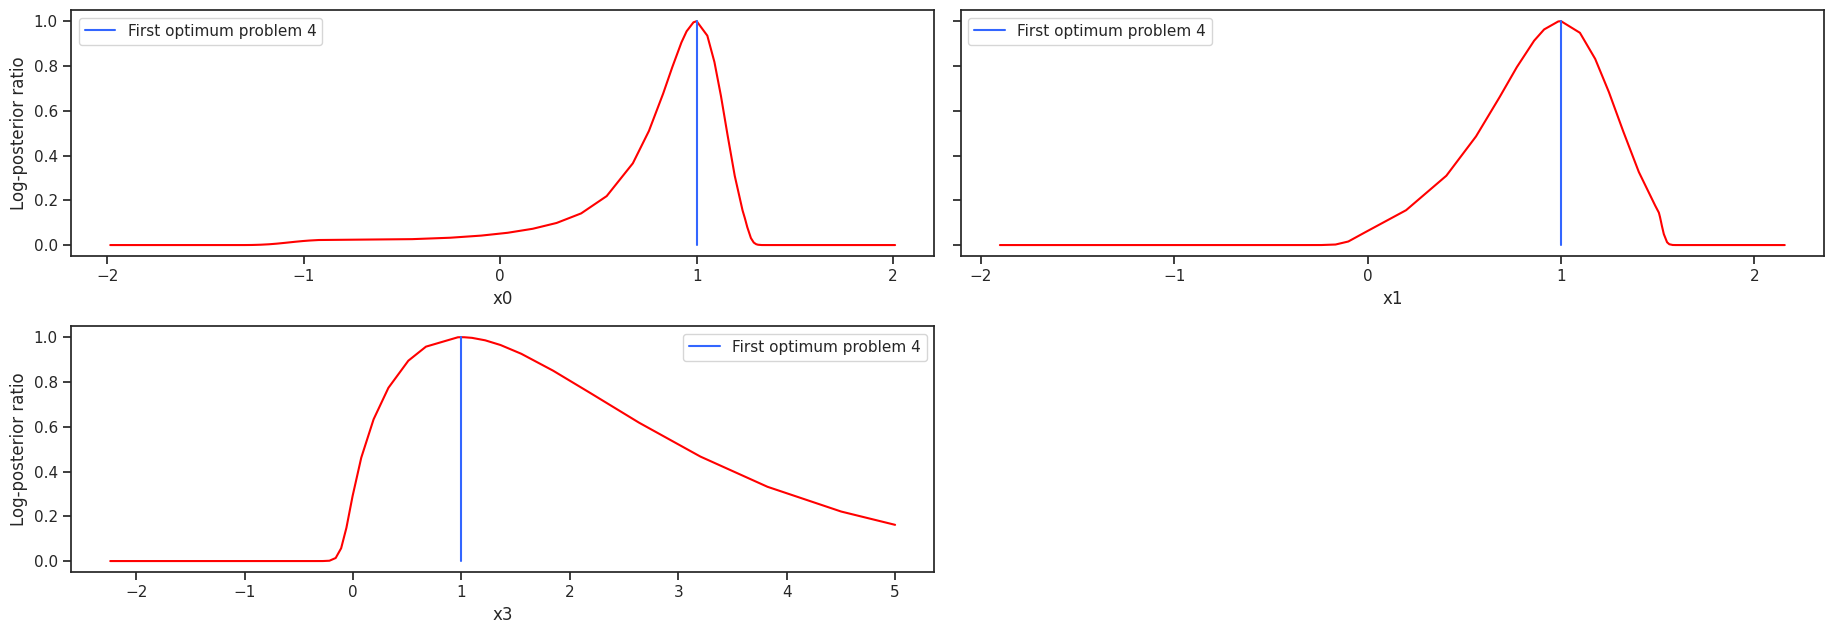

In [76]:
visualize.profiles(
    result4,
    profile_indices=[0, 1, 3],
    reference=[ref4],
)

In [77]:
result1 = profile.approximate_parameter_profile(
    problem=problem1,
    result=result1,
    profile_index=np.array([0, 1, 3, 5]),
    result_index=0,
    n_steps=1000,
)



visualize.profile_cis(
    result1, confidence_level=0.95, profile_list=2, show_bounds=True
)



Computing Hessian/FIM as not available in result.


IndexError: index 5 is out of bounds for axis 0 with size 4